In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import save_image
from model import *
import json

In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset_path = './dataset'
x_dim = 784

batch_size = 64

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# initialize model
model = VAE_expanding(input_size=((28,28)), device=DEVICE)

# construct model with encoder and decoder configuration
encoder_config = [256, 256, 32]
decoder_config = [256, 256, 784]

model.construct(encoder_config, decoder_config)

model_name = "VAE_2hid_15eps"

model.load_state_dict(torch.load(f"saved_model/{model_name}.pth"))
model.eval()

VAE_expanding(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (hidden_to_mu): Linear(in_features=256, out_features=32, bias=True)
  (hidden_to_logvar): Linear(in_features=256, out_features=32, bias=True)
)

In [5]:
model.eval()

with torch.no_grad():
    loop = tqdm(enumerate(test_loader), f'Testing', leave=True, total=len(test_loader))
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)
        break

  0%|          | 0/157 [00:04<?, ?it/s]?, ?it/s]


torch.Size([64, 784])
torch.Size([64, 784])
Data shape: torch.Size([64, 784])


<Figure size 3000x1337.5 with 0 Axes>

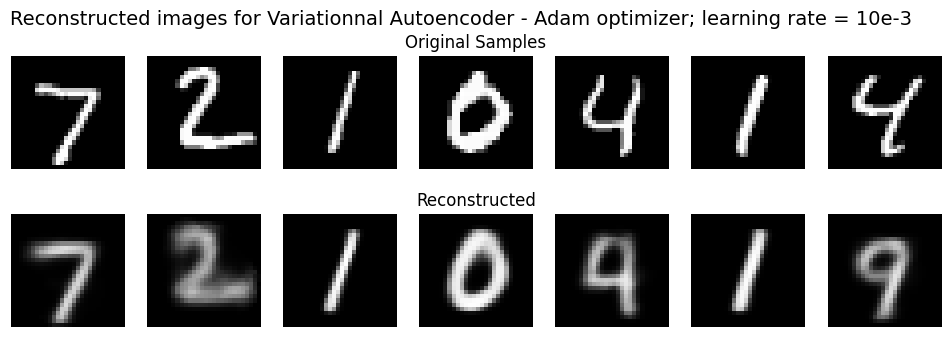

In [6]:
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(batch_size, x_dim)
        
        print(img.shape)
        recon, _, _ = model(img.to(DEVICE))
        print(recon.shape)
        break
         
plt.figure(dpi=250, figsize=(12, 5.35))
fig, ax = plt.subplots(2, 7, figsize=(12, 3.75)) 

print("Data shape:", img.shape)

fig.suptitle("Reconstructed images for Variationnal Autoencoder - Adam optimizer; learning rate = 10e-3", fontsize=14)

for i in range(7):
    ax[0, i].imshow(img[i].cpu().numpy().reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    ax[1, i].imshow(recon[i].cpu().numpy().reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')

ax[0, 3].set_title('Original Samples', fontsize=12)
ax[1, 3].set_title('Reconstructed', fontsize=12)
plt.show()


### Generate sample from noise distribution

In [7]:
latent_dim = 32
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = model.decoder(noise)

In [8]:
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")
save_image(generated_images.view(batch_size, 1, 28, 28), f'img/{model_name}_{timestamp}.png')

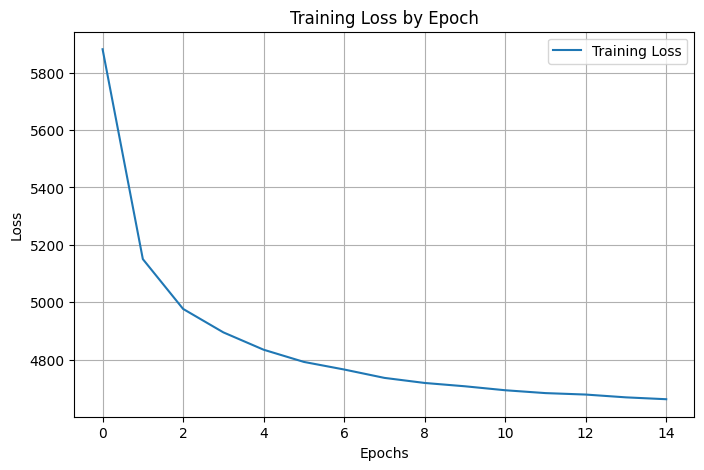

: 

In [9]:
# Load the training loss data
with open(f'saved_loss/train_loss_{model_name}.json', 'r') as f:
    train_loss_list = json.load(f)

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss by Epoch')
plt.legend()
plt.grid(True)
plt.show()